# Disease Prediction Model Code

This code cell imports all the necessary libraries and modules required for the following tasks:
- **Data Handling**: Libraries such as `NumPy` and `pandas` are used for data manipulation and analysis.
- **Data Visualization**: `matplotlib` and `seaborn` are included for creating insightful visualizations.
- **Machine Learning**: `scikit-learn`, `XGBoost`, and `imblearn` are used for building, optimizing, and evaluating machine learning models.
- **Pipeline and Feature Engineering**: Tools from `scikit-learn` for preprocessing, feature selection, and pipeline creation.
- **Model Evaluation**: Metrics such as accuracy, F1-score, confusion matrix, and classification reports to assess model performance.
- **Dataset Profiling**: `ydata_profiling` is used to generate comprehensive profiling reports for exploratory data analysis.
- **Model Deployment**: `mlflow` and `joblib` support model tracking, saving, and deployment.
- **Database Operations**: The `sqlite3` library is used for interacting with SQLite databases.
- **Inline Plotting**: `%matplotlib inline` ensures all visualizations are displayed inline in the notebook.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from ydata_profiling import ProfileReport  
import mlflow
from mlflow.models import infer_signature
import joblib
import sqlite3
from sqlite3 import Error
from xgboost import XGBClassifier
%matplotlib inline

This code cell is responsible for loading the diabetes dataset into the notebook for analysis. It uses the `pandas` library to read the data from a CSV file named `diabetes.csv` located in the current directory. The dataset is stored in a DataFrame called `beforeDataClean`.

This step is critical for initializing the data analysis process and serves as the foundation for all subsequent data manipulation and modeling tasks.

In [2]:
# Load dataset
beforeDataClean = pd.read_csv(r".\diabetes.csv")

1. **Dataset Profiling**:
   - Uses `ProfileReport` from the `ydata_profiling` library to generate a comprehensive profiling report for the `beforeDataClean` dataset.
   - The report provides insights into dataset structure, data types, missing values, and summary statistics.
   - The output is displayed directly within the notebook as an iframe.

2. **Correlation Analysis**:
   - Computes the correlation matrix for all numerical columns in the dataset.
   - Visualizes the correlation matrix using a heatmap created with `seaborn`, providing a clear representation of relationships between numerical features.
   - Customizes the heatmap with annotations, a color map ("coolwarm"), and a title for improved readability.

Generating profile report...


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

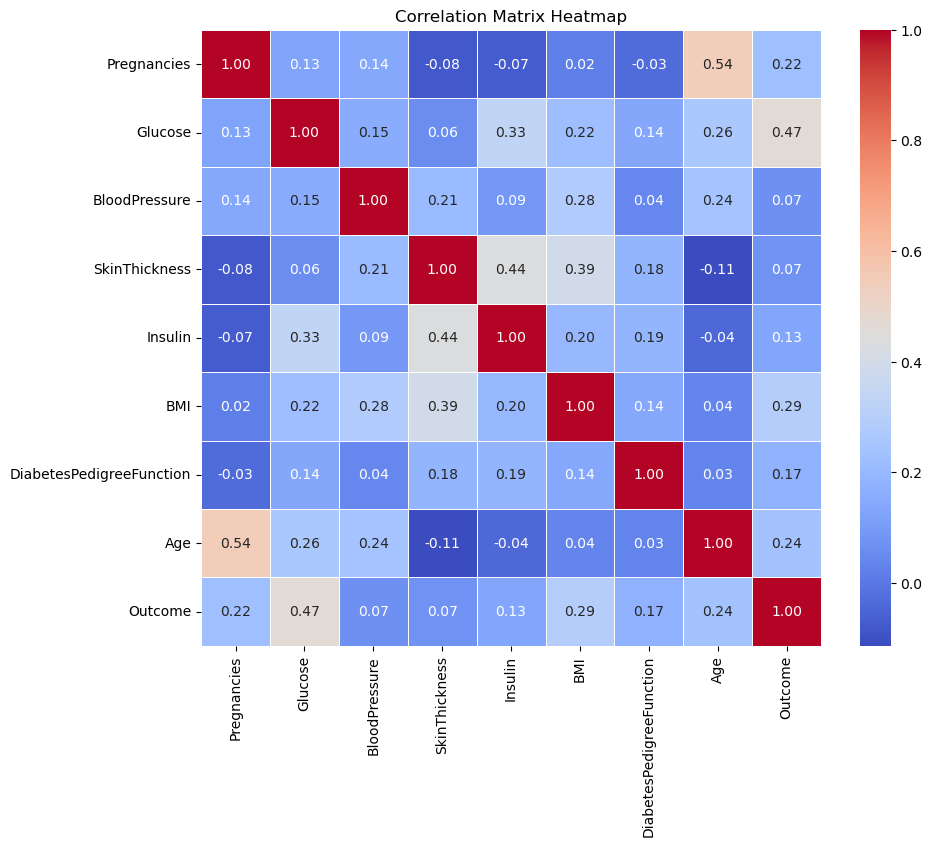

In [3]:

# Generate Profile Report
print("Generating profile report...")
profile = ProfileReport(beforeDataClean, title="Diabetes Dataset Profiling Report")
profile.to_notebook_iframe()
# Compute the correlation matrix for numerical columns
numerical_columns = beforeDataClean.select_dtypes(include=['number'])
correlation_matrix = numerical_columns.corr()
plt.figure(figsize=(10, 8))  # Set the figure size
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

This code cell focuses on cleaning the dataset to prepare it for further analysis and modeling. The following steps are performed:

1. **Create a Copy**:
   - A deep copy of the `beforeDataClean` DataFrame is created to avoid modifying the original dataset. The copy is stored in `afterDataClean`.

2. **Replace Invalid Values**:
   - Columns `Glucose`, `BloodPressure`, `SkinThickness`, `Insulin`, and `BMI` are checked for invalid entries (e.g., zeros).
   - Invalid entries are replaced with `NaN` to handle them appropriately during the cleaning process.

3. **Fill Missing Values**:
   - Missing values in `Glucose` and `BloodPressure` are filled with their respective column means.
   - Missing values in `SkinThickness`, `Insulin`, and `BMI` are filled with their respective column medians for robustness against outliers.

4. **Check for Remaining Missing Values**:
   - Prints the count of remaining `NaN` values to ensure the dataset is free of missing data.

5. **Prepare Final Data**:
   - The cleaned data is stored in the `data` DataFrame, which will be used in subsequent processing steps.

In [4]:
# Data Cleaning
afterDataClean = beforeDataClean.copy(deep=True)
afterDataClean[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']] = (
    afterDataClean[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].replace(0, np.nan))
afterDataClean['Glucose'] = afterDataClean['Glucose'].fillna(round(afterDataClean['Glucose'].mean()))
afterDataClean['BloodPressure'] = afterDataClean['BloodPressure'].fillna(round(afterDataClean['BloodPressure'].mean()))
afterDataClean['SkinThickness'] = afterDataClean['SkinThickness'].fillna(round(afterDataClean['SkinThickness'].median()))
afterDataClean['Insulin'] = afterDataClean['Insulin'].fillna(round(afterDataClean['Insulin'].median()))
afterDataClean['BMI'] = afterDataClean['BMI'].fillna(round(afterDataClean['BMI'].median()))

# Check for remaining NaN values
print("Remaining NaN values:", afterDataClean.isnull().sum())


# Final data for processing
data = afterDataClean

Remaining NaN values: Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


This code cell manages database operations by establishing a connection, creating tables, inserting data, and retrieving it for analysis. The following key steps are performed:

1. **Database Connection**:
   - A `create_connection` function is defined to establish a connection to an SQLite database.
   - Includes optional functionality to delete an existing database file before creating a new one.
   - Ensures foreign key constraints are enabled.

2. **Table Creation**:
   - Three tables are created in the database:
     - `Patient`: Stores basic patient information (e.g., `Pregnancies`, `Age`).
     - `HealthMetrics`: Stores health-related metrics (e.g., `Glucose`, `BloodPressure`, `BMI`).
     - `Outcome`: Stores the diabetes status of patients.
   - The `create_table` function executes SQL statements to define the schema for each table.

3. **Data Insertion**:
   - Three separate functions insert data into the respective tables:
     - `insert_patient_data`: Inserts patient demographic data.
     - `insert_health_metrics`: Inserts health metrics data, linking it to patient IDs.
     - `insert_outcome`: Inserts diabetes outcome data, also linked to patient IDs.
   - Uses `conn.commit()` to ensure changes are saved to the database.

4. **Data Retrieval**:
   - Combines data from all three tables using SQL `JOIN` statements.
   - Retrieves the consolidated dataset into a `pandas` DataFrame for further analysis.

5. **Data Validation**:
   - Displays the first few rows of the consolidated dataset and prints descriptive statistics to verify data integrity.

6. **Database Closure**:

In [5]:
# Database Connection Functions
def create_connection(db_file, delete_db=False):
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)
    return conn

def create_table(conn, create_table_sql):
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)

# Create database and tables
dbConnection = create_connection("normalizedData.db", True)

patientTable = '''CREATE TABLE Patient (
    PatientID INTEGER PRIMARY KEY AUTOINCREMENT,
    Pregnancies INTEGER,
    Age INT
);'''
healthMatrixTable = '''CREATE TABLE HealthMetrics (
    PatientID INTEGER,
    Glucose INTEGER,
    BloodPressure INTEGER,
    SkinThickness INTEGER,
    Insulin INTEGER,
    BMI FLOAT,
    DiabetesPedigreeFunction FLOAT,
    FOREIGN KEY (PatientID) REFERENCES Patient(PatientID)
);'''
diseaseOutcomeTable = '''CREATE TABLE Outcome (
    PatientID INTEGER,
    DiabetesStatus INTEGER,
    FOREIGN KEY (PatientID) REFERENCES Patient(PatientID)
);'''

create_table(dbConnection, patientTable)
create_table(dbConnection, healthMatrixTable)
create_table(dbConnection, diseaseOutcomeTable)

# Insert data into tables
def insert_patient_data(conn, data):
    cursor = conn.cursor()
    for _, row in data.iterrows():
        cursor.execute(
            "INSERT INTO Patient (Pregnancies, Age) VALUES (?, ?)",
            (row["Pregnancies"], row["Age"])
        )
    conn.commit()

def insert_health_metrics(conn, data):
    cursor = conn.cursor()
    patient_ids = cursor.execute("SELECT PatientID FROM Patient").fetchall()
    for _, (row, patient_id) in enumerate(zip(data.iterrows(), patient_ids)):
        row = row[1]
        cursor.execute(
            """
            INSERT INTO HealthMetrics (
                PatientID, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction
            ) VALUES (?, ?, ?, ?, ?, ?, ?)
            """,
            (
                patient_id[0],
                row["Glucose"],
                row["BloodPressure"],
                row["SkinThickness"],
                row["Insulin"],
                row["BMI"],
                row["DiabetesPedigreeFunction"]
            )
        )
    conn.commit()

def insert_outcome(conn, data):
    cursor = conn.cursor()
    patient_ids = cursor.execute("SELECT PatientID FROM Patient").fetchall()
    for _, (row, patient_id) in enumerate(zip(data.iterrows(), patient_ids)):
        row = row[1]
        cursor.execute(
            "INSERT INTO Outcome (PatientID, DiabetesStatus) VALUES (?, ?)",
            (patient_id[0], row["Outcome"])
        )
    conn.commit()

insert_patient_data(dbConnection, data)
insert_health_metrics(dbConnection, data)
insert_outcome(dbConnection, data)
print("Data inserted successfully!")

# Load data from database
dataFromTable = '''SELECT 
    p.PatientID, 
    p.Pregnancies, 
    p.Age, 
    hm.Glucose, 
    hm.BloodPressure, 
    hm.SkinThickness, 
    hm.Insulin, 
    hm.BMI, 
    hm.DiabetesPedigreeFunction, 
    o.DiabetesStatus AS Outcome
FROM Patient p
JOIN HealthMetrics hm ON p.PatientID = hm.PatientID
JOIN Outcome o ON p.PatientID = o.PatientID;'''
data = pd.read_sql_query(dataFromTable, dbConnection)
print(data.head())
dbConnection.close()
print(data.describe())

Data inserted successfully!
   PatientID  Pregnancies  Age  Glucose  BloodPressure  SkinThickness  \
0          1            6   50      148             72             35   
1          2            1   31       85             66             29   
2          3            8   32      183             64             29   
3          4            1   21       89             66             23   
4          5            0   33      137             40             35   

   Insulin   BMI  DiabetesPedigreeFunction  Outcome  
0      125  33.6                     0.627        1  
1      125  26.6                     0.351        0  
2      125  23.3                     0.672        1  
3       94  28.1                     0.167        0  
4      168  43.1                     2.288        1  
        PatientID  Pregnancies         Age     Glucose  BloodPressure  \
count  768.000000   768.000000  768.000000  768.000000     768.000000   
mean   384.500000     3.845052   33.240885  121.688802      72.

This code cell prepares the dataset for machine learning by performing feature engineering, addressing class imbalance, and defining preprocessing steps. The following operations are performed:

1. **Feature and Target Separation**:
   - Separates the dataset into features (`X`) and target variable (`y`), dropping irrelevant columns such as `PatientID`.

2. **Feature Engineering**:
   - Creates new interaction features to capture relationships between variables:
     - `Age_BMI`: The product of `Age` and `BMI`.
     - `Glucose_BloodPressure`: The product of `Glucose` and `BloodPressure`.

3. **Class Imbalance Handling**:
   - Applies SMOTE (Synthetic Minority Oversampling Technique) to balance the class distribution in the target variable.
   - Resamples the data to ensure equitable representation of all target classes, printing the resulting class distribution for validation.

4. **Data Splitting**:
   - Splits the resampled data into training and testing sets using an 80-20 split.

5. **Pipeline Definition**:
   - Defines key preprocessing steps for a machine learning pipeline:
     - **Scaler**: Standardizes the data using `StandardScaler` for uniform scaling.
     - **PCA**: Reduces dimensionality while retaining 95% of the variance.
     - **Feature Selector**: Removes low-variance features using `VarianceThreshold`.


In [6]:
# Split features and target
X = data.drop(['Outcome','PatientID'], axis=1)
y = data['Outcome']

# Feature Engineering (Experiment #3)
data['Age_BMI'] = data['Age'] * data['BMI']
data['Glucose_BloodPressure'] = data['Glucose'] * data['BloodPressure']

# Handle imbalance
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)
print("Class distribution after SMOTE:", np.bincount(y_res))

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Define Pipeline Steps
scaler = StandardScaler()
pca = PCA(n_components=0.95)
feature_selector = VarianceThreshold(threshold=0.01)

Class distribution after SMOTE: [500 500]


This code cell initializes several machine learning models and defines custom experiments to enhance predictive performance. The following components are included:

1. **Standard Models**:
   - **Logistic Regression (`log_reg`)**: A linear model for binary classification with a maximum iteration limit of 200.
   - **XGBoost Classifier (`xgb`)**: An optimized gradient boosting implementation tuned for log loss.
   - **Ridge Classifier (`ridge`)**: A linear classifier with regularization to prevent overfitting.
   - **Random Forest Classifier (`random_forest`)**: An ensemble model with 200 estimators and a maximum depth of 10.
   - **Gradient Boosting Classifier (`gb`)**: A boosting model for improved predictive accuracy.

2. **Custom Experiments**:
   - **Stacking Classifier (`stacking_clf`)**:
     - Combines predictions from `RandomForest` and `GradientBoosting` models.
     - Uses `LogisticRegression` as the final estimator.
     - Employs passthrough, allowing raw features to be included alongside base predictions for the final model.
   - **Custom XGBoost (`custom_xgb`)**:
     - Extends XGBoost with 300 estimators, a maximum depth of 15, and a learning rate of 0.05 to improve model performance on complex datasets.

In [7]:
# Models
log_reg = LogisticRegression(max_iter=200, random_state=42)
xgb = XGBClassifier(eval_metric='logloss', random_state=42)
ridge = RidgeClassifier(random_state=42)
random_forest = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
gb = GradientBoostingClassifier(random_state=42)

# Custom Experiments (Experiment #6 and #7)
stacking_clf = StackingClassifier(
    estimators=[('rf', random_forest), ('gb', gb)], final_estimator=LogisticRegression(),
    passthrough=True
)
custom_xgb = XGBClassifier(n_estimators=300, max_depth=15, learning_rate=0.05, random_state=42)


This code cell defines preprocessing and classification pipelines for various machine learning models. Each pipeline standardizes the data, applies feature selection, reduces dimensionality, and fits a specific classifier. The following components are included in each pipeline:

1. **Preprocessing Steps**:
   - **Scaler**: Standardizes the features using `StandardScaler` to ensure uniform scaling.
   - **Feature Selector**: Removes low-variance features with `VarianceThreshold`.
   - **PCA**: Reduces dimensionality by retaining 95% of the variance, optimizing computational efficiency.

2. **Classifiers**:
   - `Logistic Regression`: A linear model for binary classification.
   - `Ridge Classifier`: A regularized linear model for robustness against overfitting.
   - `Random Forest`: An ensemble method using decision trees for classification.
   - `XGBClassifier`: A high-performance gradient boosting algorithm.
   - `Gradient Boosting`: Another boosting algorithm optimized for accuracy.
   - `Stacking`: Combines predictions from `Random Forest` and `Gradient Boosting` with `Logistic Regression` as the final estimator.
   - `Custom XGB`: An extended XGBoost model with tuned hyperparameters for enhanced performance.

3. **Pipeline Dictionary**:
   - Stores all pipelines in a dictionary named `pipelines`, allowing for easy iteration and evaluation of different models.

In [8]:
# Define Pipelines
pipelines = {
    'Logistic Regression': Pipeline([
        ('scaler', scaler),
        ('feature_selector', feature_selector),
        ('pca', pca),
        ('classifier', log_reg)
    ]),
    'Ridge Classifier': Pipeline([
        ('scaler', scaler),
        ('feature_selector', feature_selector),
        ('pca', pca),
        ('classifier', ridge)
    ]),
    'Random Forest': Pipeline([
        ('scaler', scaler),
        ('feature_selector', feature_selector),
        ('pca', pca),
        ('classifier', random_forest)
    ]),
    'XGBClassifier': Pipeline([
        ('scaler', scaler),
        ('feature_selector', feature_selector),
        ('pca', pca),
        ('classifier', xgb)
    ]),
    'Gradient Boosting': Pipeline([
        ('scaler', scaler),
        ('feature_selector', feature_selector),
        ('pca', pca),
        ('classifier', gb)
    ]),
    'Stacking': Pipeline([
        ('scaler', scaler),
        ('feature_selector', feature_selector),
        ('pca', pca),
        ('classifier', stacking_clf)
    ]),
    'Custom XGB': Pipeline([
        ('scaler', scaler),
        ('feature_selector', feature_selector),
        ('pca', pca),
        ('classifier', custom_xgb)
    ])
}

This code cell initializes the setup for evaluating machine learning models using cross-validation. The following steps are performed:

1. **Results Dictionary**:
   - Creates an empty dictionary named `results` to store the evaluation metrics for each model.

2. **Cross-Validation Strategy**:
   - Utilizes `StratifiedKFold` to split the dataset into 10 folds while preserving the class distribution in each fold.
   - Parameters:
     - `n_splits=10`: Divides the dataset into 10 folds for training and validation.
     - `shuffle=True`: Shuffles the data before splitting to ensure randomness.

In [9]:
results = {}
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)


1. **MLflow Configuration**:
   - Sets up the MLflow tracking server using the provided URI, username, and password.
   - Defines the experiment name as `"diseasePredictionSystemModel"` to organize logged runs.

2. **Cross-Validation and Evaluation**:
   - Iterates through each pipeline in the `pipelines` dictionary.
   - Performs cross-validation on the training set (`X_train`, `y_train`) using `StratifiedKFold` and calculates F1 scores.
   - Trains the pipeline on the full training set and evaluates it on the test set (`X_test`, `y_test`).
   - Computes various performance metrics, including:
     - Mean and standard deviation of cross-validation F1 scores.
     - Accuracy and F1 score on the test set.
     - Confusion matrix components: true positives (TP), true negatives (TN), false positives (FP), and false negatives (FN).

3. **Results Storage**:
   - Stores the evaluation metrics for each model in the `results` dictionary for comparison.

4. **MLflow Logging**:
   - Logs key metrics such as mean cross-validation F1 score, accuracy, and confusion matrix components to MLflow.
   - Captures the model's signature (input-output schema) using `infer_signature`.
   - Logs the trained pipeline to MLflow as an artifact for reproducibility and deployment.
   - Assigns a registered model name based on the pipeline's key in the dictionary.

5. **Model Management**:
   - MLflow handles the storage and organization of trained models, allowing easy comparison and deployment in production.

In [10]:
MLFLOW_TRACKING_URI = "https://dagshub.com/s3akash/diseasePredictionSystemModel.mlflow"
os.environ['MLFLOW_TRACKING_USERNAME'] = 's3akash'
os.environ['MLFLOW_TRACKING_PASSWORD'] = '4d779774d517aa973e2858c5d93af0e87a4ca457'
mlflow.set_tracking_uri(uri=MLFLOW_TRACKING_URI)
mlflow.set_experiment("diseasePredictionSystemModel")
for name, pipeline in pipelines.items():
    cv_f1_scores = cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring='f1')
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    results[name] = {
        'Mean CV F1 Score': cv_f1_scores.mean(),
        'Std CV F1 Score': cv_f1_scores.std(),
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'Confusion Matrix': cm,
        'TP': cm[1, 1],
        'TN': cm[0, 0],
        'FP': cm[0, 1],
        'FN': cm[1, 0]
    }
# Log metrics
    mlflow.log_metric("mean_cv_f1_score", cv_f1_scores.mean())
    mlflow.log_metric("std_cv_f1_score", cv_f1_scores.std())
    mlflow.log_metric("accuracy", accuracy_score(y_test, y_pred))
    mlflow.log_metric("f1_score", f1_score(y_test, y_pred))
    mlflow.log_metric("true_positives", cm[1, 1])
    mlflow.log_metric("true_negatives", cm[0, 0])
    mlflow.log_metric("false_positives", cm[0, 1])
    mlflow.log_metric("false_negatives", cm[1, 0])

    signature = infer_signature(X_train, pipeline.predict(X_train))
        
    # Log the model
    mlflow.sklearn.log_model(
        sk_model=pipeline,
        artifact_path="model",
        signature=signature,
        input_example=X_train,
        registered_model_name=name,
    )
    

2024/12/20 23:51:03 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|none|n|0: for no warning or exception
    - warn|w|warning|1: for a printed warning
    - error|e|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet

c:\Users\Windows\anaconda3\Lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your i

Registered model 'Logistic Regression' already exists. Creating a new version of this model...
2024/12/20 23:51:18 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Logistic Regression, version 29
Created version '29' of model 'Logistic Regression'.
c:\Users\Windows\anaconda3\Lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models

Registered model 'Ridge Classifier' already exists. Creating a new version of this model...
2024/12/20 23:51:33 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Ridge Classifier, version 4
Created version '4' of model 'Ridge Classifier'.
c:\Users\Windows\anaconda3\Lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handl

Registered model 'Random Forest' already exists. Creating a new version of this model...
2024/12/20 23:51:53 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Random Forest, version 29
Created version '29' of model 'Random Forest'.
c:\Users\Windows\anaconda3\Lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-int

Registered model 'XGBClassifier' already exists. Creating a new version of this model...
2024/12/20 23:52:11 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBClassifier, version 4
Created version '4' of model 'XGBClassifier'.
c:\Users\Windows\anaconda3\Lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integ

Registered model 'Gradient Boosting' already exists. Creating a new version of this model...
2024/12/20 23:52:30 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Gradient Boosting, version 29
Created version '29' of model 'Gradient Boosting'.
c:\Users\Windows\anaconda3\Lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#

Registered model 'Stacking' already exists. Creating a new version of this model...
2024/12/20 23:54:05 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Stacking, version 20
Created version '20' of model 'Stacking'.
c:\Users\Windows\anaconda3\Lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-miss

Registered model 'Custom XGB' already exists. Creating a new version of this model...
2024/12/20 23:54:23 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Custom XGB, version 4
Created version '4' of model 'Custom XGB'.


This code cell visualizes the performance of various machine learning models, identifies the best-performing model, and saves it for future use. The following steps are performed:

1. **Results Conversion**:
   - Converts the `results` dictionary into a pandas DataFrame for better organization and analysis.
   - Transposes the DataFrame to align models as rows and metrics as columns for easier interpretation.

2. **F1-Score Visualization**:
   - Creates a bar plot comparing the "Mean CV F1 Score" and "F1 Score" for each model.
   - Customizes the plot with:
     - A title: "F1 Score Comparison Across Models."
     - Labels for axes: "Models" (x-axis) and "F1 Score" (y-axis).
     - Rotated x-axis labels for better readability.
   - Displays the plot to provide a clear comparison of model performance.

3. **Best Model Identification**:
   - Determines the best-performing model based on the highest accuracy score in the results DataFrame.
   - Stores the name of the best model for subsequent steps.

4. **Model Saving**:
   - Saves the pipeline of the best-performing model as a `.pkl` file (`disease_prediction_model2.pkl`) using `joblib`.
   - Prints the name of the best model for reference.

                    Mean CV F1 Score Std CV F1 Score Accuracy  F1 Score  \
Logistic Regression         0.724046          0.0518    0.745  0.753623   
Ridge Classifier            0.711978        0.059794     0.75  0.754902   
Random Forest               0.794854        0.062576    0.785  0.807175   
XGBClassifier               0.791712        0.052744     0.79  0.801887   
Gradient Boosting           0.771374        0.046129     0.76  0.779817   
Stacking                    0.786486        0.051623     0.79  0.809091   
Custom XGB                  0.791181        0.057984    0.805  0.820276   

                         Confusion Matrix  TP  TN  FP  FN  
Logistic Regression  [[71, 28], [23, 78]]  78  71  28  23  
Ridge Classifier     [[73, 26], [24, 77]]  77  73  26  24  
Random Forest        [[67, 32], [11, 90]]  90  67  32  11  
XGBClassifier        [[73, 26], [16, 85]]  85  73  26  16  
Gradient Boosting    [[67, 32], [16, 85]]  85  67  32  16  
Stacking             [[69, 30], [12, 89

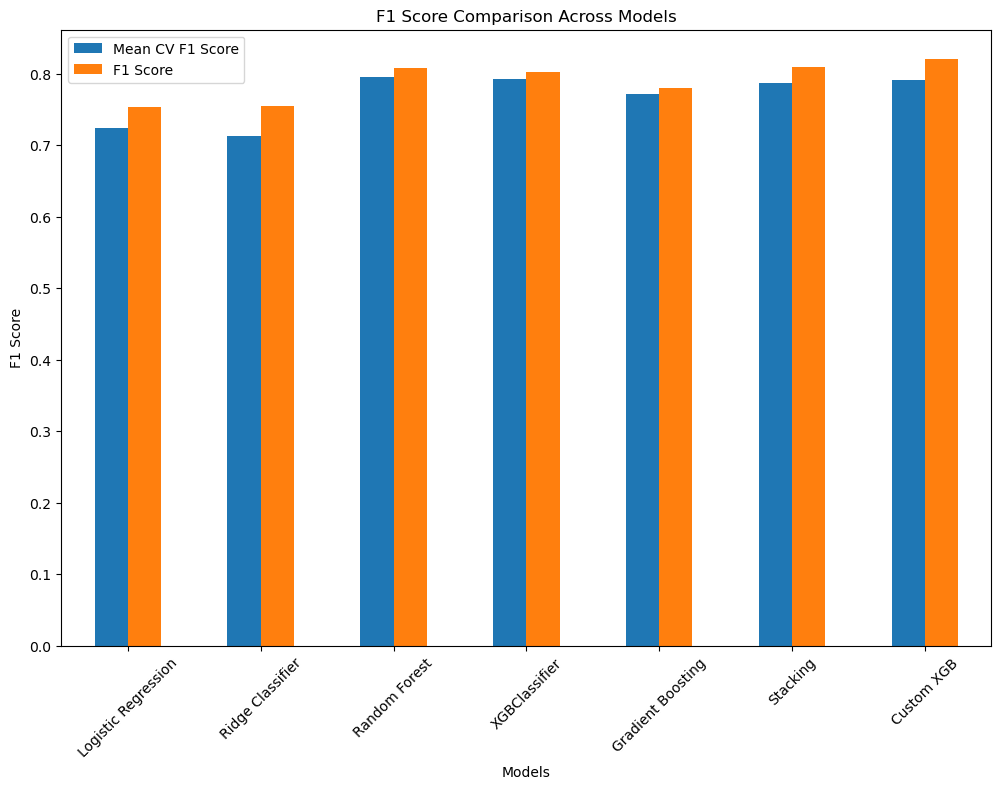

Best Model: Custom XGB


In [11]:

# Generate F1-score plot
results_df = pd.DataFrame(results).T
print(results_df)
results_df[['Mean CV F1 Score', 'F1 Score']].plot(kind='bar', figsize=(12, 8))
plt.title('F1 Score Comparison Across Models')
plt.xlabel('Models')
plt.ylabel('F1 Score')
plt.xticks(rotation=45)
plt.show()

# Save best model
best_model_name = results_df['Accuracy'].idxmax()
joblib.dump(pipelines[best_model_name], './disease_prediction_model2.pkl')
print(f"Best Model: {best_model_name}")

1. **Test Model Function**:
   - `test_model`: A function to evaluate the model on individual test cases.
   - Key steps:
     - Adds feature-engineered columns (`Age_BMI` and `Glucose_BloodPressure`) to match the training set.
     - Reorders columns in the test case to align with the model's expected input structure.
     - Prints the test case input and the model's prediction for better interpretability.

2. **Example Test Cases**:
   - Five test cases are created as pandas DataFrames, each with the following features:
     - `Pregnancies`, `Age`, `Glucose`, `BloodPressure`, `SkinThickness`, `Insulin`, `BMI`, and `DiabetesPedigreeFunction`.
   - These test cases represent diverse scenarios to evaluate the model's prediction capability.

3. **Best Model Evaluation**:
   - Retrieves the best-performing pipeline from the `pipelines` dictionary using `best_model_name`.
   - Uses the `test_model` function to predict outcomes for the defined test cases.

4. **Output**:
   - Displays the input values and predictions for each test case.
   - Helps validate the model's performance on unseen data and provides insights into how feature engineering affects predictions.

In [12]:
# Test Cases
def test_model(model_pipeline, test_cases, feature_columns):
    for i, test_case in enumerate(test_cases):
        # Add feature engineering
        test_case['Age_BMI'] = test_case['Age'] * test_case['BMI']
        test_case['Glucose_BloodPressure'] = test_case['Glucose'] * test_case['BloodPressure']
        # Reorder columns to match training
        test_case = test_case[feature_columns]
        print(test_case)
        prediction = model_pipeline.predict(test_case)
        print(f"Test Case {i+1}: Input: {test_case.values.flatten().tolist()}, Prediction: {prediction[0]}")

# Example Test Cases
test_case_1 = pd.DataFrame({
    'Pregnancies': [1],
    'Age': [22],
    'Glucose': [85],
    'BloodPressure': [70],
    'SkinThickness': [20],
    'Insulin': [50],
    'BMI': [25.5],
    'DiabetesPedigreeFunction': [0.201]
})

test_case_2 = pd.DataFrame({
    'Pregnancies': [5],
    'Age': [45],
    'Glucose': [165],
    'BloodPressure': [85],
    'SkinThickness': [40],
    'Insulin': [150],
    'BMI': [35.0],
    'DiabetesPedigreeFunction': [0.543]
})

test_case_3 = pd.DataFrame({
    'Pregnancies': [3],
    'Age': [33],
    'Glucose': [110],
    'BloodPressure': [70],
    'SkinThickness': [25],
    'Insulin': [90],
    'BMI': [28.0],
    'DiabetesPedigreeFunction': [0.350]
})

test_case_4 = pd.DataFrame({
    'Pregnancies': [0],
    'Age': [19],
    'Glucose': [75],
    'BloodPressure': [60],
    'SkinThickness': [18],
    'Insulin': [40],
    'BMI': [22.0],
    'DiabetesPedigreeFunction': [0.150]
})

test_case_5 = pd.DataFrame({
    'Pregnancies': [8],
    'Age': [50],
    'Glucose': [180],
    'BloodPressure': [90],
    'SkinThickness': [45],
    'Insulin': [230],
    'BMI': [40.0],
    'DiabetesPedigreeFunction': [0.750]
})

test_cases = [test_case_1, test_case_2, test_case_3, test_case_4, test_case_5]

# Evaluate Best Model
feature_columns = X_train.columns.tolist()
best_pipeline = pipelines[best_model_name]
test_model(best_pipeline, test_cases, feature_columns)

   Pregnancies  Age  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            1   22       85             70             20       50  25.5   

   DiabetesPedigreeFunction  
0                     0.201  
Test Case 1: Input: [1.0, 22.0, 85.0, 70.0, 20.0, 50.0, 25.5, 0.201], Prediction: 0
   Pregnancies  Age  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            5   45      165             85             40      150  35.0   

   DiabetesPedigreeFunction  
0                     0.543  
Test Case 2: Input: [5.0, 45.0, 165.0, 85.0, 40.0, 150.0, 35.0, 0.543], Prediction: 1
   Pregnancies  Age  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            3   33      110             70             25       90  28.0   

   DiabetesPedigreeFunction  
0                      0.35  
Test Case 3: Input: [3.0, 33.0, 110.0, 70.0, 25.0, 90.0, 28.0, 0.35], Prediction: 1
   Pregnancies  Age  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            0   19     

1. **Define Test Case**:
   - Creates a dictionary (`test_case`) with the following patient attributes:
     - `Pregnancies`, `Age`, `Glucose`, `BloodPressure`, `SkinThickness`, `Insulin`, `BMI`, and `DiabetesPedigreeFunction`.
   - The test case represents a hypothetical patient scenario for prediction.

2. **POST Request**:
   - Sends the test case data as JSON to the API endpoint (`http://127.0.0.1:8000/predict`) using the `requests.post` method.
   - The endpoint is expected to process the input data and return a prediction.

3. **Response Handling**:
   - Prints the HTTP status code to confirm the success or failure of the request.
   - Prints the JSON response from the API, which contains the prediction result.

**Use Case**:
- This setup is ideal for integrating the machine learning model into a web application or service, allowing real-time predictions based on user-provided data.

**Output Example**:
- **Status Code**: Indicates the success of the API call (e.g., 200 for success).
- **Response JSON**: Contains the prediction result, such as `{"prediction": 1}`, where the value represents the predicted disease outcome.

In [15]:
import requests
import json

# Define test payload
test_case = {
    "Pregnancies": 8,
    "Age": 50,
    "Glucose": 180,
    "BloodPressure": 90,
    "SkinThickness": 45,
    "Insulin": 230,
    "BMI": 40.0,
    "DiabetesPedigreeFunction": 0.750
}
# Make POST request
response = requests.post("http://159.203.101.120:8008/predict", json=test_case)

# Print response
print("Status Code:", response.status_code)
print("Response JSON:", response.json())

Status Code: 200
Response JSON: {'prediction': 1}
